<a href="https://colab.research.google.com/github/John1495/BBC-NYOK/blob/main/Linear_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install category-encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.4 MB/s eta 0:00:00


In [ ]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 MB 3.5 MB/s eta 0:00:00


In [ ]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.impute import SimpleImputer
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Load data with optimized dtypes
df = dd.read_csv("/kaggle/train.csv", dtype={
    'Podcast_Name': 'category',
    'Episode_Title': 'category',
    'Genre': 'category',
    'Publication_Day': 'category',
    'Publication_Time': 'category',
    'Episode_Sentiment': 'category'
}).compute()

# Separate feature types
numerical_features = ['Episode_Length_minutes', 'Guest_Popularity_percentage', 'Number_of_Ads']
categorical_features = ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

# Impute missing values
df[numerical_features] = SimpleImputer(strategy="median").fit_transform(df[numerical_features])
df[categorical_features] = SimpleImputer(strategy="most_frequent").fit_transform(df[categorical_features])

print("✅ Missing Values After Imputation:")
print(df.isnull().sum())

✅ Missing Values After Imputation:
id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
dtype: int64


In [ ]:
# Aggregations
podcast_features = df.groupby("Podcast_Name").agg(
    avg_podcast_listening_time=('Listening_Time_minutes', 'mean'),
    median_podcast_listening_time=('Listening_Time_minutes', 'median'),
    total_podcast_listens=('Listening_Time_minutes', 'count'),
    std_podcast_listening_time=('Listening_Time_minutes', 'std'),
    avg_episode_length=('Episode_Length_minutes', 'mean'),
    avg_host_popularity=('Host_Popularity_percentage', 'mean'),
    avg_guest_popularity=('Guest_Popularity_percentage', 'mean'),
    avg_num_ads=('Number_of_Ads', 'mean')
).reset_index()

genre_features = df.groupby("Genre").agg(
    avg_genre_listening_time=('Listening_Time_minutes', 'mean'),
    avg_genre_episode_length=('Episode_Length_minutes', 'mean'),
    total_genre_listens=('Listening_Time_minutes', 'count')
).reset_index()

sentiment_features = df.groupby("Episode_Sentiment").agg(
    avg_sentiment_listening_time=('Listening_Time_minutes', 'mean'),
    total_sentiment_listens=('Listening_Time_minutes', 'count')
).reset_index()

day_features = df.groupby("Publication_Day").agg(
    avg_day_listening_time=('Listening_Time_minutes', 'mean'),
    total_day_listens=('Listening_Time_minutes', 'count')
).reset_index()

# Merge engineered features
df = df.merge(podcast_features, on="Podcast_Name", how="left")
df = df.merge(genre_features, on="Genre", how="left")
df = df.merge(sentiment_features, on="Episode_Sentiment", how="left")
df = df.merge(day_features, on="Publication_Day", how="left")
df.fillna(0, inplace=True)  # Handle any remaining NaNs

In [ ]:
from datetime import datetime, timedelta
import pandas as pd

# Example fixed start date (feel free to adjust this)
start_date = datetime(2023, 1, 1)

# Weekday string to weekday index mapping
weekday_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

# Function to get the next occurrence of a weekday from start_date
def get_date_from_weekday(weekday_str):
    try:
        target_weekday = weekday_mapping[weekday_str]
        delta_days = (target_weekday - start_date.weekday()) % 7
        return start_date + timedelta(days=delta_days)
    except KeyError:
        print(f"Unknown weekday: {weekday_str}")
        return pd.NaT  # Return Not-a-Time if there's an issue

# Apply the transformation
df['Publication_Day'] = df['Publication_Day'].apply(get_date_from_weekday)

# Ensure it's datetime type
df['Publication_Day'] = pd.to_datetime(df['Publication_Day'])

# Check results
print(df['Publication_Day'].head())


0   2023-01-05
1   2023-01-07
2   2023-01-03
3   2023-01-02
4   2023-01-02
Name: Publication_Day, dtype: datetime64[ns]


In [ ]:
# --- Ordinal Time Features ---
df = df.sort_values('Publication_Day')

# 💡 Days since start
df['Days_Since_Start'] = (df['Publication_Day'] - df['Publication_Day'].min()).dt.days

# 💡 Lag features
df['Lag_1_Listening'] = df['Listening_Time_minutes'].shift(1)
df['Lag_1_Podcast'] = df.groupby('Podcast_Name')['Listening_Time_minutes'].shift(1)

# 💡 Diff features
df['Listening_Diff'] = df['Listening_Time_minutes'].diff()
df['Podcast_Diff'] = df.groupby('Podcast_Name')['Listening_Time_minutes'].diff()

# 💡 Rolling features (3-day trend)
df['Rolling_3'] = df['Listening_Time_minutes'].rolling(window=3).mean()
df['Rolling_3_Podcast'] = df.groupby('Podcast_Name')['Listening_Time_minutes'].transform(lambda x: x.rolling(window=3).mean())

# 💡 Seasonality: Weekday
df['Weekday'] = df['Publication_Day'].dt.weekday
df = pd.get_dummies(df, columns=['Weekday'], prefix='Day')

# 💡 Optional: sine/cosine transformation for day-of-year seasonality
df['Day_Sin'] = np.sin(2 * np.pi * df['Publication_Day'].dt.dayofyear / 365)
df['Day_Cos'] = np.cos(2 * np.pi * df['Publication_Day'].dt.dayofyear / 365)

# --- Final clean-up ---
df.fillna(0, inplace=True)

In [ ]:
#Prepare data
df_model = df.copy()
df_model.drop(['id', 'Episode_Title'], axis=1, inplace=True)  # Dropping non-relevant columns

# Encode categorical variables
for col in ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']:
    df_model[col] = LabelEncoder().fit_transform(df_model[col])

# Define features and target variable
X = df_model.drop('Listening_Time_minutes', axis=1)
y = df_model['Listening_Time_minutes']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Make predictions
preds = rf_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, preds))

# Output the RMSE
print(f"Random Forest RMSE: {rmse:.2f}")

Random Forest RMSE: 0.40


📊 Cross-Validated RMSE: 0.45 (±0.06)


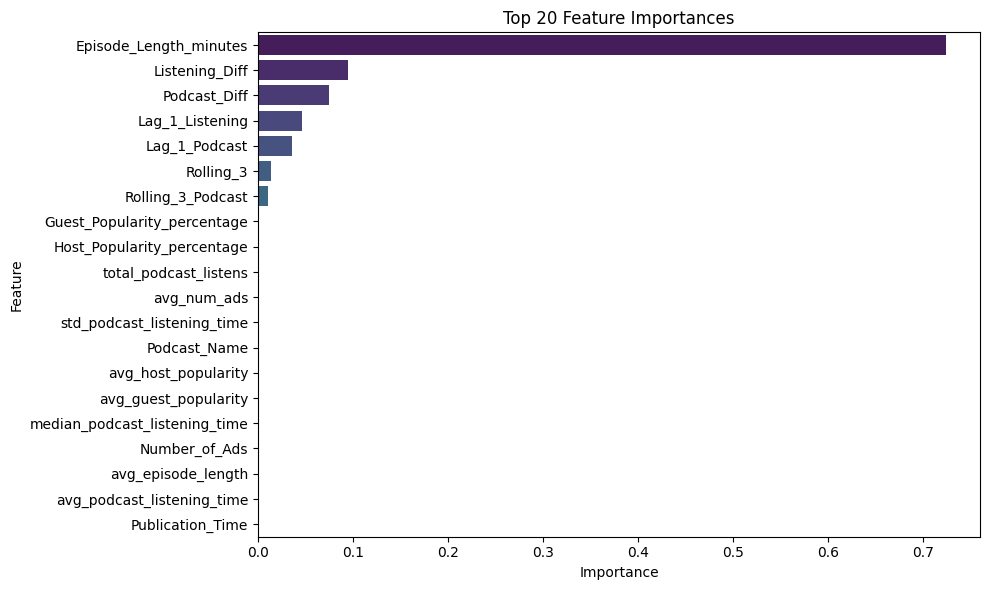


📈 Model Comparison:


,Model,RMSE
0,Random Forest,0.396843
1,XGBoost,1.752054
2,Gradient Boosting,4.401572



🔍 Final Random Forest Test RMSE: 0.40


In [ ]:
# Prepare data
df_model = df.copy()
df_model.drop(['id', 'Episode_Title'], axis=1, inplace=True)

# Encode categorical variables
for col in ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']:
    df_model[col] = LabelEncoder().fit_transform(df_model[col])

# Define features and target
X = df_model.drop('Listening_Time_minutes', axis=1)
y = df_model['Listening_Time_minutes']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 1. Cross-Validation
cv_scores = cross_val_score(
    rf_model,
    X_train,
    y_train,
    cv=5,
    scoring='neg_root_mean_squared_error'
)
print(f"📊 Cross-Validated RMSE: {-cv_scores.mean():.2f} (±{cv_scores.std():.2f})")

# 2. Feature Importance
importances = rf_model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})\
    .sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="viridis")
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

# 3. Model Comparison
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    results.append({"Model": name, "RMSE": rmse})

results_df = pd.DataFrame(results).sort_values("RMSE")
print("\n📈 Model Comparison:")
display(results_df)

# Original model's test RMSE
preds = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"\n🔍 Final Random Forest Test RMSE: {rmse:.2f}")